图片缩放与插值算法
===

# 1.最近邻域插值算法
假设原图片为src，目标图片为dst，那么就有
$$\begin{cases}
dstX&=srcX \times \frac{srcH}{dstH} \\
dstY&=srcY \times \frac{srcW}{dstW}
\end{cases}$$

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

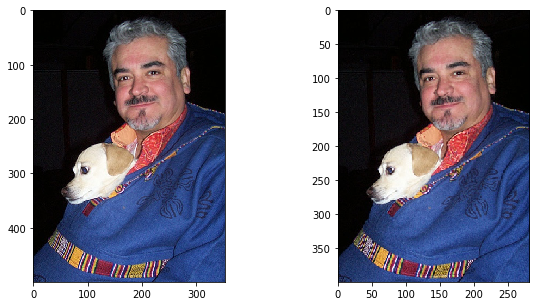

In [7]:
ratio = 0.8
image = cv2.imread("Images/01/09/01.jpg", 1)
shapes = image.shape
height = shapes[0]
width = shapes[1]
dst_height = int(height * ratio)
dst_width = int(width * ratio)
dst_image = np.zeros((dst_height, dst_width, 3), dtype=np.uint8)

for x in range(0, dst_height):
    for y in range(0, dst_width):
        dst_X = int(x * (height * 1.0 / dst_height))
        dst_Y = int(y * (width * 1.0 / dst_width))
        dst_image[x, y] = image[dst_X, dst_Y]

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 2, 1)
show_img1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img1)

plt.subplot(1, 2, 2)
show_img2 = cv2.cvtColor(dst_image, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img2)

最近邻域插值算法比较简单直观，但由于采用了浮点数四舍五入的方法，所以缩放后的图片质量往往不高

# 2.双线性插值算法

(500, 353, 3)


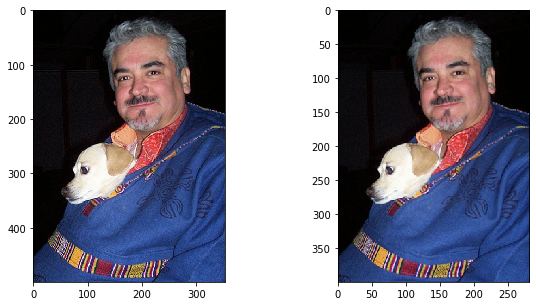

In [13]:
scale_x, scale_y = float(width) / dst_width, float(height) / dst_height
dst_image = np.zeros((dst_height, dst_width, 3), dtype=np.uint8)
print(image.shape)
for i in range(3):
    for dst_Y in range(0, dst_height):
        for dst_X in range(0, dst_width):
            src_X = (dst_X + 0.5) * scale_x - 0.5
            src_Y = (dst_Y + 0.5) * scale_y - 0.5
            src_X0 = int(np.floor(src_X))
            src_X1 = min(src_X0 + 1, width - 1)
            src_Y0 = int(np.floor(src_Y))
            src_Y1 = min(src_Y0 + 1, height - 1)
            
            temp0 = (src_X1 - src_X) * image[src_Y0, src_X0, i] + (src_X - src_X0) * image[src_Y0, src_X1, i]
            temp1 = (src_X1 - src_X) * image[src_Y1, src_X0, i] + (src_X - src_X0) * image[src_Y1, src_X1, i]
            dst_image[dst_Y, dst_X, i] = int((src_Y1 - src_Y) * temp0 + (src_Y - src_Y0) * temp1)
plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 2, 1)
show_img1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img1)

plt.subplot(1, 2, 2)
show_img2 = cv2.cvtColor(dst_image, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img2)

双线性插值运算量大，但是缩放后的质量比较高，而且具有低通滤波器的性质，所以可能会使图像轮廓在一定程度上变得模糊